# 이미지 분할 및 배경 흐리게 처리하기

In [29]:
# 라이브러리 로드
import cv2
import os
import urllib
import numpy as np
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation

## 함수 정의

### 이미지 불러오기

In [30]:
def load_image(image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Loaded Image")
    plt.show()
    return img


### 모델 다운로드

In [31]:
def download_model(model_url, model_path):
    urllib.request.urlretrieve(model_url, model_path)

### 모델 로드

In [32]:
def load_model(model_path):
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_path)
    return model

## 오브젝트 컬러 지정

In [95]:
def get_object_colors(output, seg_values):
    unique_colors = np.unique(output.reshape(-1, output.shape[2]), axis=0)
    object_colors = [tuple(color) for color in unique_colors if tuple(color) != (0, 0, 0)]
    return object_colors

### 이미지 분할

In [96]:
# Pascal VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
    
def segment_image(model, image_path):
    seg_values, output = model.segmentAsPascalvoc(image_path)
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Image")
    plt.show()

    object_colors = get_object_colors(output, seg_values)
    
    # 마스킹된 객체가 무엇인지 출력
    for idx, class_id in enumerate(seg_values['class_ids']):
        print(f"Detected object: {LABEL_NAMES[class_id]}")
        print(f"Color map: {object_colors[idx]}")
    
    return seg_values, output, object_colors

### 마스크 생성

In [97]:
def create_mask(output, seg_values, object_colors):
    detected_objects = seg_values['class_ids']
    
    if len(detected_objects) == 0:
        print("Error: No objects detected, cannot create mask.")
        return None
    
    print("Select the object you want to mask:")
    for class_id in detected_objects:
        print(f"{class_id}: {LABEL_NAMES[class_id]}")
    
    selected = int(input("Enter the index of the object: "))
    
    if selected not in detected_objects:
        print("Error: Invalid selection.")
        return None
    
    seg_color = object_colors[detected_objects.index(selected)]
    print(f"Selected object color map: {seg_color}")  # 선택한 객체의 컬러맵 출력
    
    mask = np.all(output == seg_color, axis=-1).astype(np.uint8) * 255
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.show()
    
    return mask


### 블러 처리

In [35]:
def blur_background(image, kernel_size):
    blurred = cv2.blur(image, kernel_size)
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.title("Blurred Background")
    plt.show()
    return blurred


### 이미지 합성

In [36]:
def combine_images(original, mask, blurred):
    # 라벨 이름 출력
    for class_id in segvalues['class_ids']:
        print(f"Class ID: {class_id}, Label: {LABEL_NAMES[class_id]}")

    # 사용자 입력 프롬프트
    selected_class_id = int(input("Enter the Class ID of the object you want to mask: "))
    selected_color = segvalues['masks'][:,:,selected_class_id]  # 선택한 클래스 ID에 해당하는 마스크 컬러

    # 형상 일치를 위한 리사이징
    if original.shape != mask.shape[0:2]:
        mask = cv2.resize(mask, (original.shape[1], original.shape[0]))
    if original.shape != blurred.shape:
        blurred = cv2.resize(blurred, (original.shape[1], original.shape[0]))

    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    bg_mask = cv2.bitwise_not(mask_color)

    # 형상 확인
    print("Shape of original:", original.shape)
    print("Shape of mask_color:", mask_color.shape)
    print("Shape of blurred:", blurred.shape)
    
    if blurred.shape == bg_mask.shape:
        bg_blur = cv2.bitwise_and(blurred, bg_mask)
    else:
        print("Error: The shapes of the blurred and background mask images do not match.")
        return None

    combined = np.where(mask_color == 255, original, bg_blur)

    # 원본 이미지와 처리된 이미지 함께 출력
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.title("Combined Image")

    plt.show()
    return combined


## 메인 코드 실행

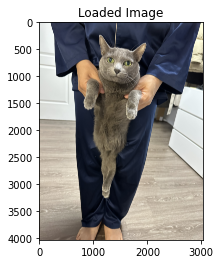

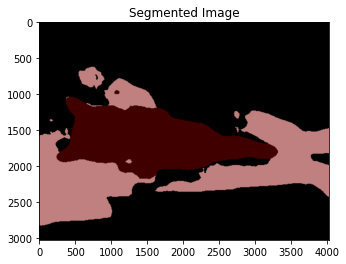

Detected object: background
Color map: [0 0 0]
Detected object: cat
Color map: [0 0 0]
Detected object: person
Color map: [0 0 0]


In [94]:
img_path = './catwithman.jpeg'
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    
# 이미지 불러오기
original_image = load_image(img_path)
    
# 모델 다운로드
download_model(model_url, model_file)
    
# 모델 불러오기
model = load_model(model_file)

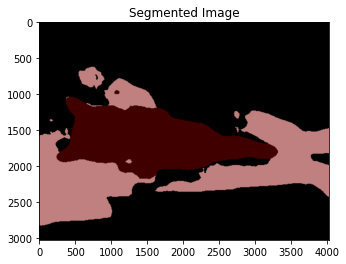

Detected object: background
Color map: (0, 0, 1)
Detected object: cat
Color map: (0, 0, 2)
Detected object: person
Color map: (0, 0, 3)


ValueError: too many values to unpack (expected 2)

In [98]:
# 이미지 세그멘테이션
seg_values, output = segment_image(model, img_path)

Select the object you want to mask:
0: background
8: cat
15: person
Enter the index of the object: 8
Selected object color: [0 0 8]


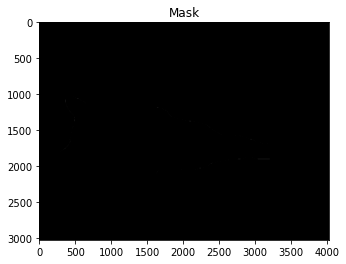

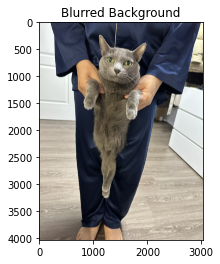

NameError: name 'segvalues' is not defined

In [90]:
# 마스크 생성
mask = create_mask(output, seg_values)
    
if mask is not None:
    # 배경 흐리게 하기
    blurred = blur_background(original_image, (13, 13))
        
    # 이미지 합성
    combined = combine_images(original_image, mask, blurred)

In [ ]:
if mask is not None:
    # 배경 흐리게 하기
    blurred = blur_background(original_image, (13, 13))
        
    # 이미지 합성
    combined = combine_images(original_image, mask, blurred)